In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
df_classes = pd.read_csv("dataset/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("dataset/elliptic_txs_features.csv", header=None)

No. of transactions (nodes) = 203769, <br />
No. of bitcoin flows (edges) = 234355

In [3]:
df_classes['class'].value_counts()

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

Class 1 = Illicit, <br />
Class 2 = Licit

In [4]:
df_edgelist.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [5]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


As the features data is anonymized, the colnames are not have proper naming. To derive from this columns: <br />
1. column_0 looks like transactionId
2. column_1 looks like timesteps for each node. timesteps have an interval of ~2 weeks. Each timestep contains connected component of transactions, which appeared on blockchin within <3 hours between eachother.

In [6]:
df_features.columns = ['txId', 'time_step'] + [f'local_feat_{i}' for i in range(1, 94)] + [f'aggr_feat_{i}' for i in range(1, 73)]

In [7]:
df_features.head()

,txId,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,local_feat_8,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [8]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3

In [9]:
print("shape of classes dataframe: ", df_classes.shape)
print("shape of edgelist dataframe: ", df_edgelist.shape)
print("shape of features dataframe: ", df_features.shape)

shape of classes dataframe:  (203769, 2)
shape of edgelist dataframe:  (234355, 2)
shape of features dataframe:  (203769, 167)


### EDA

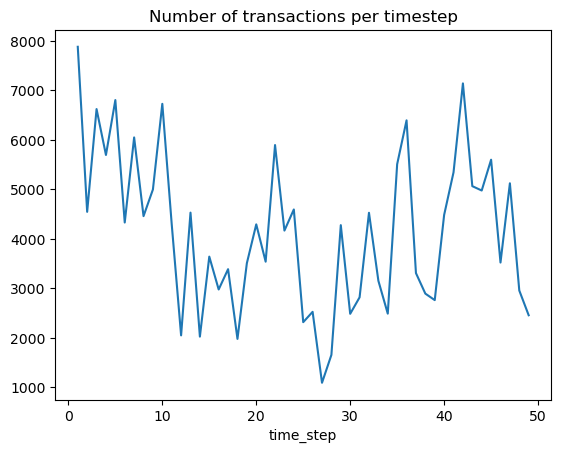

In [10]:
df_features['time_step'].value_counts().sort_index().plot()
plt.title('Number of transactions per timestep')
plt.show()

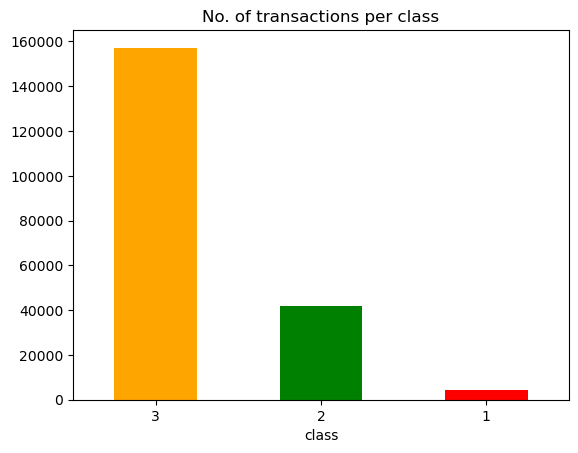

In [12]:
df_classes['class'].value_counts().plot(kind = 'bar', color = ['orange', 'green', 'red'])
plt.xticks(rotation = 0)
plt.title('No. of transactions per class')
plt.show()

In [13]:
df_class_feature = pd.merge(df_classes, df_features)
df_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [14]:
group_class_feature = df_class_feature.groupby(['class', 'time_step'])['txId'].count().reset_index()
group_class_feature.columns = ['Class', 'Time Step', 'Transaction Count']
group_class_feature.head()

,Class,Time Step,Transaction Count
0,3,1,5733
1,3,2,3427
2,3,3,5342
3,3,4,4253
4,3,5,4921


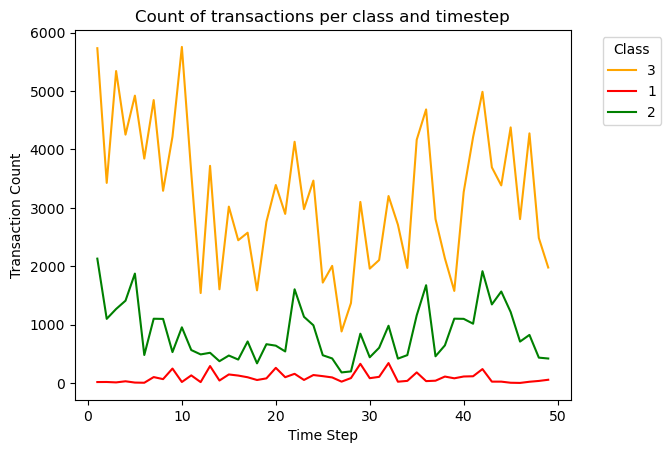

In [15]:
sns.lineplot(data = group_class_feature, x = 'Time Step', y = 'Transaction Count', hue = 'Class', palette = ['orange',
    'red', 'green'])
plt.title('Count of transactions per class and timestep')
plt.legend(title = 'Class', bbox_to_anchor=(1.05, 1), loc = 2)
plt.show()

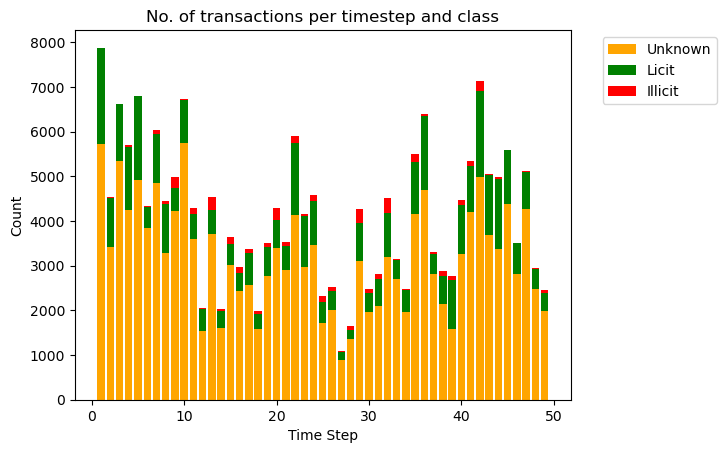

In [16]:
class1 = group_class_feature[group_class_feature['Class'] == '1']
class2 = group_class_feature[group_class_feature['Class'] == '2']
class3 = group_class_feature[group_class_feature['Class'] == 3]

p1 = plt.bar(class3['Time Step'], class3['Transaction Count'], color = 'orange')

p2 = plt.bar(class2['Time Step'], class2['Transaction Count'], color = 'green'
             , bottom = class3['Transaction Count'])

p3 = plt.bar(class1['Time Step'], class1['Transaction Count'], color = 'red'
             , bottom = np.array(class3['Transaction Count']) + np.array(class2['Transaction Count']))

plt.xlabel('Time Step')
plt.ylabel('Count')
plt.title('No. of transactions per timestep and class')
plt.legend(['Unknown', 'Licit', 'Illicit'], bbox_to_anchor = (1.05,1), loc = 2)
plt.show()

In [17]:
group_class_feature.groupby(['Class'])['Transaction Count'].max()

Class
3    5755
1     342
2    2130
Name: Transaction Count, dtype: int64

In [18]:
group_class_feature.loc[group_class_feature['Transaction Count'] == 342]

,Class,Time Step,Transaction Count
80,1,32,342


In [19]:
illicit_ids = df_class_feature.loc[(df_class_feature['time_step'] == 32) & (df_class_feature['class'] == '1'), 'txId']
illicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

In [20]:
illicit_edges.head()

,txId1,txId2
145842,355009662,91806025
145881,355003977,355238405
145913,355102230,355102228
145948,355998263,159817356
145982,355128718,355006712


In [22]:
#graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

#pos = nx.spring_layout(graph)
#nx.draw(graph, with_labels = False, pos = pos)

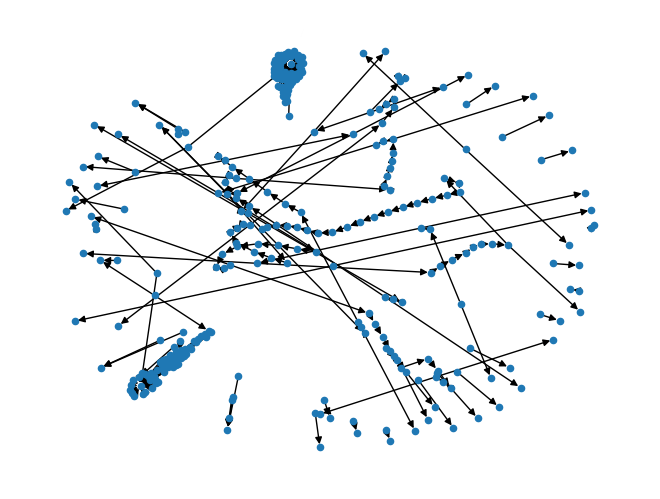

In [23]:
graph = nx.from_pandas_edgelist(illicit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels = False, pos = pos, node_size = 20)

> From the above graph it is noticeable that there is pattern of long transaction chain for most of the illicit transactions.

In [24]:
licit_ids = df_class_feature.loc[(df_class_feature['time_step'] == 32) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(licit_ids)]

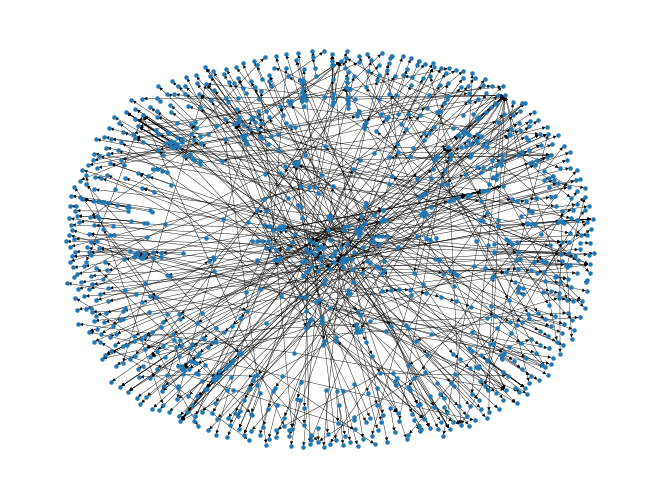

In [25]:
graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', create_using = nx.DiGraph())

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels = False, pos = pos, node_size = 5, width = 0.3, arrowsize = 5)

In [26]:
df_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


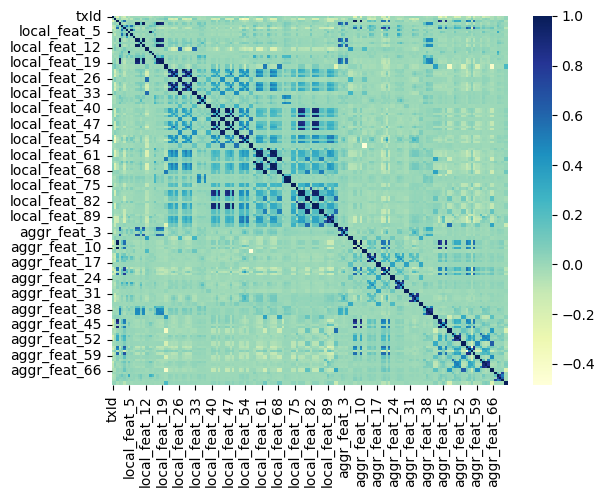

In [27]:
df_corr = df_class_feature.corr()

sns.heatmap(df_corr, cmap = 'YlGnBu')

plt.show()

<h3> Classification for class 1 and 2 transactions only </h3>

In [28]:
selected_ids = df_class_feature.loc[df_class_feature['class'] != 3, 'txId']

In [242]:
type(selected_ids)

pandas.core.series.Series

In [29]:
df_edges_selected = df_edgelist.loc[df_edgelist['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

In [30]:
df_class_features_selected = pd.merge(df_classes_selected, df_features_selected)
df_class_features_selected.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [282]:
X = df_class_features_selected.drop(columns = ['txId', 'class', 'time_step'])
y = df_class_features_selected[['class']]
y = y['class'].apply(lambda x:0 if x == '2' else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0
                                                    , stratify = y, shuffle = True)

In [283]:
X_train.shape, X_test.shape

((34923, 165), (11641, 165))

In [284]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pc_feature_names = [f"feature {i+1}" for i in range(X_train.shape[1])]

In [286]:
pca = PCA(n_components = 59)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

In [287]:
sum(explained_variance)

0.9543757080133588

In [293]:
component_weights = pca.components_

In [295]:
feature_weights_mapping = {}

for i, component in enumerate(component_weights):
    component_feature_weights = zip(pc_feature_names, component)
    feature_weights_mapping[f"Component {i+1}"] = sorted(component_feature_weights,
                                                        key = lambda x: abs(x[1]), reverse = True)

In [303]:
feature_weights_mapping['Component 3']

[('feature 1', 0.23708480219380204),
 ('feature 17', 0.22637577769667033),
 ('feature 9', 0.20671884985794112),
 ('feature 35', 0.1984263669660714),
 ('feature 19', 0.1954125693631848),
 ('feature 37', 0.19398130416008524),
 ('feature 11', 0.1906400166685233),
 ('feature 34', 0.19041824638503382),
 ('feature 18', 0.18386018087136002),
 ('feature 71', 0.1827955346630539),
 ('feature 8', 0.17916635768749437),
 ('feature 72', 0.16147937322756742),
 ('feature 73', 0.16020947257434973),
 ('feature 16', 0.14426258072212778),
 ('feature 70', 0.1418473405293473),
 ('feature 130', 0.14108691155060937),
 ('feature 131', 0.12567994189217843),
 ('feature 95', 0.12034291957269154),
 ('feature 78', -0.11934475661423233),
 ('feature 79', -0.11819342651869709),
 ('feature 84', -0.11726999692922575),
 ('feature 85', -0.11625896974728767),
 ('feature 133', 0.10612065687032309),
 ('feature 46', -0.1053254636901279),
 ('feature 43', -0.10423288094682669),
 ('feature 49', -0.10346227222646288),
 ('feature 

## Logistic Regression Classifier:

In [152]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0, max_iter = 1000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [153]:
y_pred_logistic = classifier.predict(X_test)
y_pred_logistic

array([0, 1, 0, ..., 0, 0, 0])

In [154]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [155]:
cm_logistic = confusion_matrix(y_test, y_pred_logistic)

cm_logistic

array([[10311,   194],
       [  388,   748]])

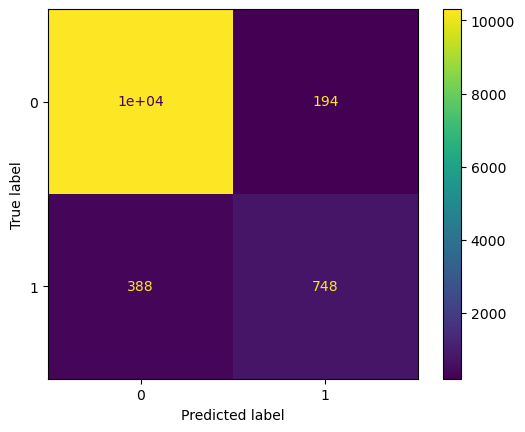

In [156]:
cm_logistic_display = ConfusionMatrixDisplay(cm_logistic, display_labels = classifier.classes_)
cm_logistic_display.plot()
plt.show()

In [157]:
precision_lr, recall_lr, f1_lr, num_lr = precision_recall_fscore_support(y_test.values, y_pred_logistic)

print("*"*28)
print("Logistic Regression Results:")
print("*"*28, '\n')
print(f"Precision: {precision_lr[1]}, Recall: {recall_lr[1]} & F1 Score: {f1_lr[1]}.")

****************************
Logistic Regression Results:
**************************** 

Precision: 0.7940552016985138, Recall: 0.6584507042253521 & F1 Score: 0.7199230028873917.


In [210]:
accuracy_lr = accuracy_score(y_test, y_pred_logistic)
print(f"The accuracy of Gradient Boosing model is {accuracy_lr}.")

The accuracy of Gradient Boosing model is 0.9500042951636457.


## Random Forest Classifier:

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [175]:
rf_classifier = RandomForestClassifier(random_state = 0, criterion = 'entropy', verbose = 0)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf

array([0, 1, 0, ..., 0, 0, 0])

In [176]:
rf_classifier.score(X_test, y_test)

0.9732840821235289

In [177]:
cm_randomforest = confusion_matrix(y_test, y_pred_rf)
cm_randomforest

array([[10476,    29],
       [  282,   854]])

In [178]:
precision_rf, recall_rf, f1_rf, num_rf = precision_recall_fscore_support(y_test, y_pred_rf)

print("*"*20)
print("Random Forest Results:")
print("*"*20, '\n')
print(f"Precision: {precision_rf[1]}, Recall: {recall_rf[1]} & F1 Score: {f1_rf[1]}.")

********************
Random Forest Results:
******************** 

Precision: 0.9671574178935447, Recall: 0.7517605633802817 & F1 Score: 0.8459633481921744.


In [207]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"The accuracy of Gradient Boosing model is {accuracy_rf}.")

The accuracy of Gradient Boosing model is 0.9732840821235289.


## Gradient Boosting Classifier:

In [180]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [201]:
gb_classifier = GradientBoostingClassifier(random_state = 0, learning_rate = 0.1)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [202]:
gb_classifier.score(X_test, y_test)

0.9676144661111589

In [203]:
y_pred_gb = gb_classifier.predict(X_test)
y_pred_gb

array([0, 1, 0, ..., 0, 0, 0])

In [204]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_gb

array([[10434,    71],
       [  306,   830]])

In [205]:
precision_gb, recall_gb, fscore_gb, num_gb = precision_recall_fscore_support(y_test, y_pred_gb)

print("*"*25)
print("Gradient Boosting Results:")
print("*"*25, '\n')
print(f"Precision: {precision_gb[1]}, Recall: {recall_gb[1]} & F1 Score: {fscore_gb[1]}.")

*************************
Gradient Boosting Results:
************************* 

Precision: 0.9211986681465039, Recall: 0.7306338028169014 & F1 Score: 0.8149239077074129.


In [206]:
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"The accuracy of Gradient Boosing model is {accuracy_gb}.")

The accuracy of Gradient Boosing model is 0.9676144661111589.


> As Random Forest Classifier has outperformed the other models for this problem. We predict the unknown records using this model next.

### Predict the Unknown Transactions

In [218]:
df_class_feature.head()
#df_class_feature['class'].value_counts()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [234]:
unknown_ids = df_class_feature.loc[df_class_feature['class'] == 3, ['txId']]

In [246]:
df_final_edgelist = df_edgelist.loc[df_edgelist['txId1'].isin(unknown_ids.squeeze())]
df_final_classes = df_classes.loc[df_classes['txId'].isin(unknown_ids.squeeze())]
df_final_features = df_features.loc[df_features['txId'].isin(unknown_ids.squeeze())]

In [252]:
df_final_class_feature = pd.merge(df_final_classes, df_final_features)

df_final_class_feature.head()

,txId,class,time_step,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,local_feat_7,...,aggr_feat_63,aggr_feat_64,aggr_feat_65,aggr_feat_66,aggr_feat_67,aggr_feat_68,aggr_feat_69,aggr_feat_70,aggr_feat_71,aggr_feat_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,3,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [258]:
X_unknown = df_final_class_feature.drop(columns = ['txId', 'class', 'time_step'])
y_unknown = df_final_class_feature[['class']]
y_unknown = y_unknown['class'].apply(lambda x:0 if x == '2' else 1)

In [259]:
y_pred_unknown = rf_classifier.predict(X_unknown)
y_pred_unknown

/Users/siddharthhaveliwala/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 165 features, but RandomForestClassifier is expecting 59 features as input.

## PCA by methods:

In [50]:
X_mean = X.mean()

X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std

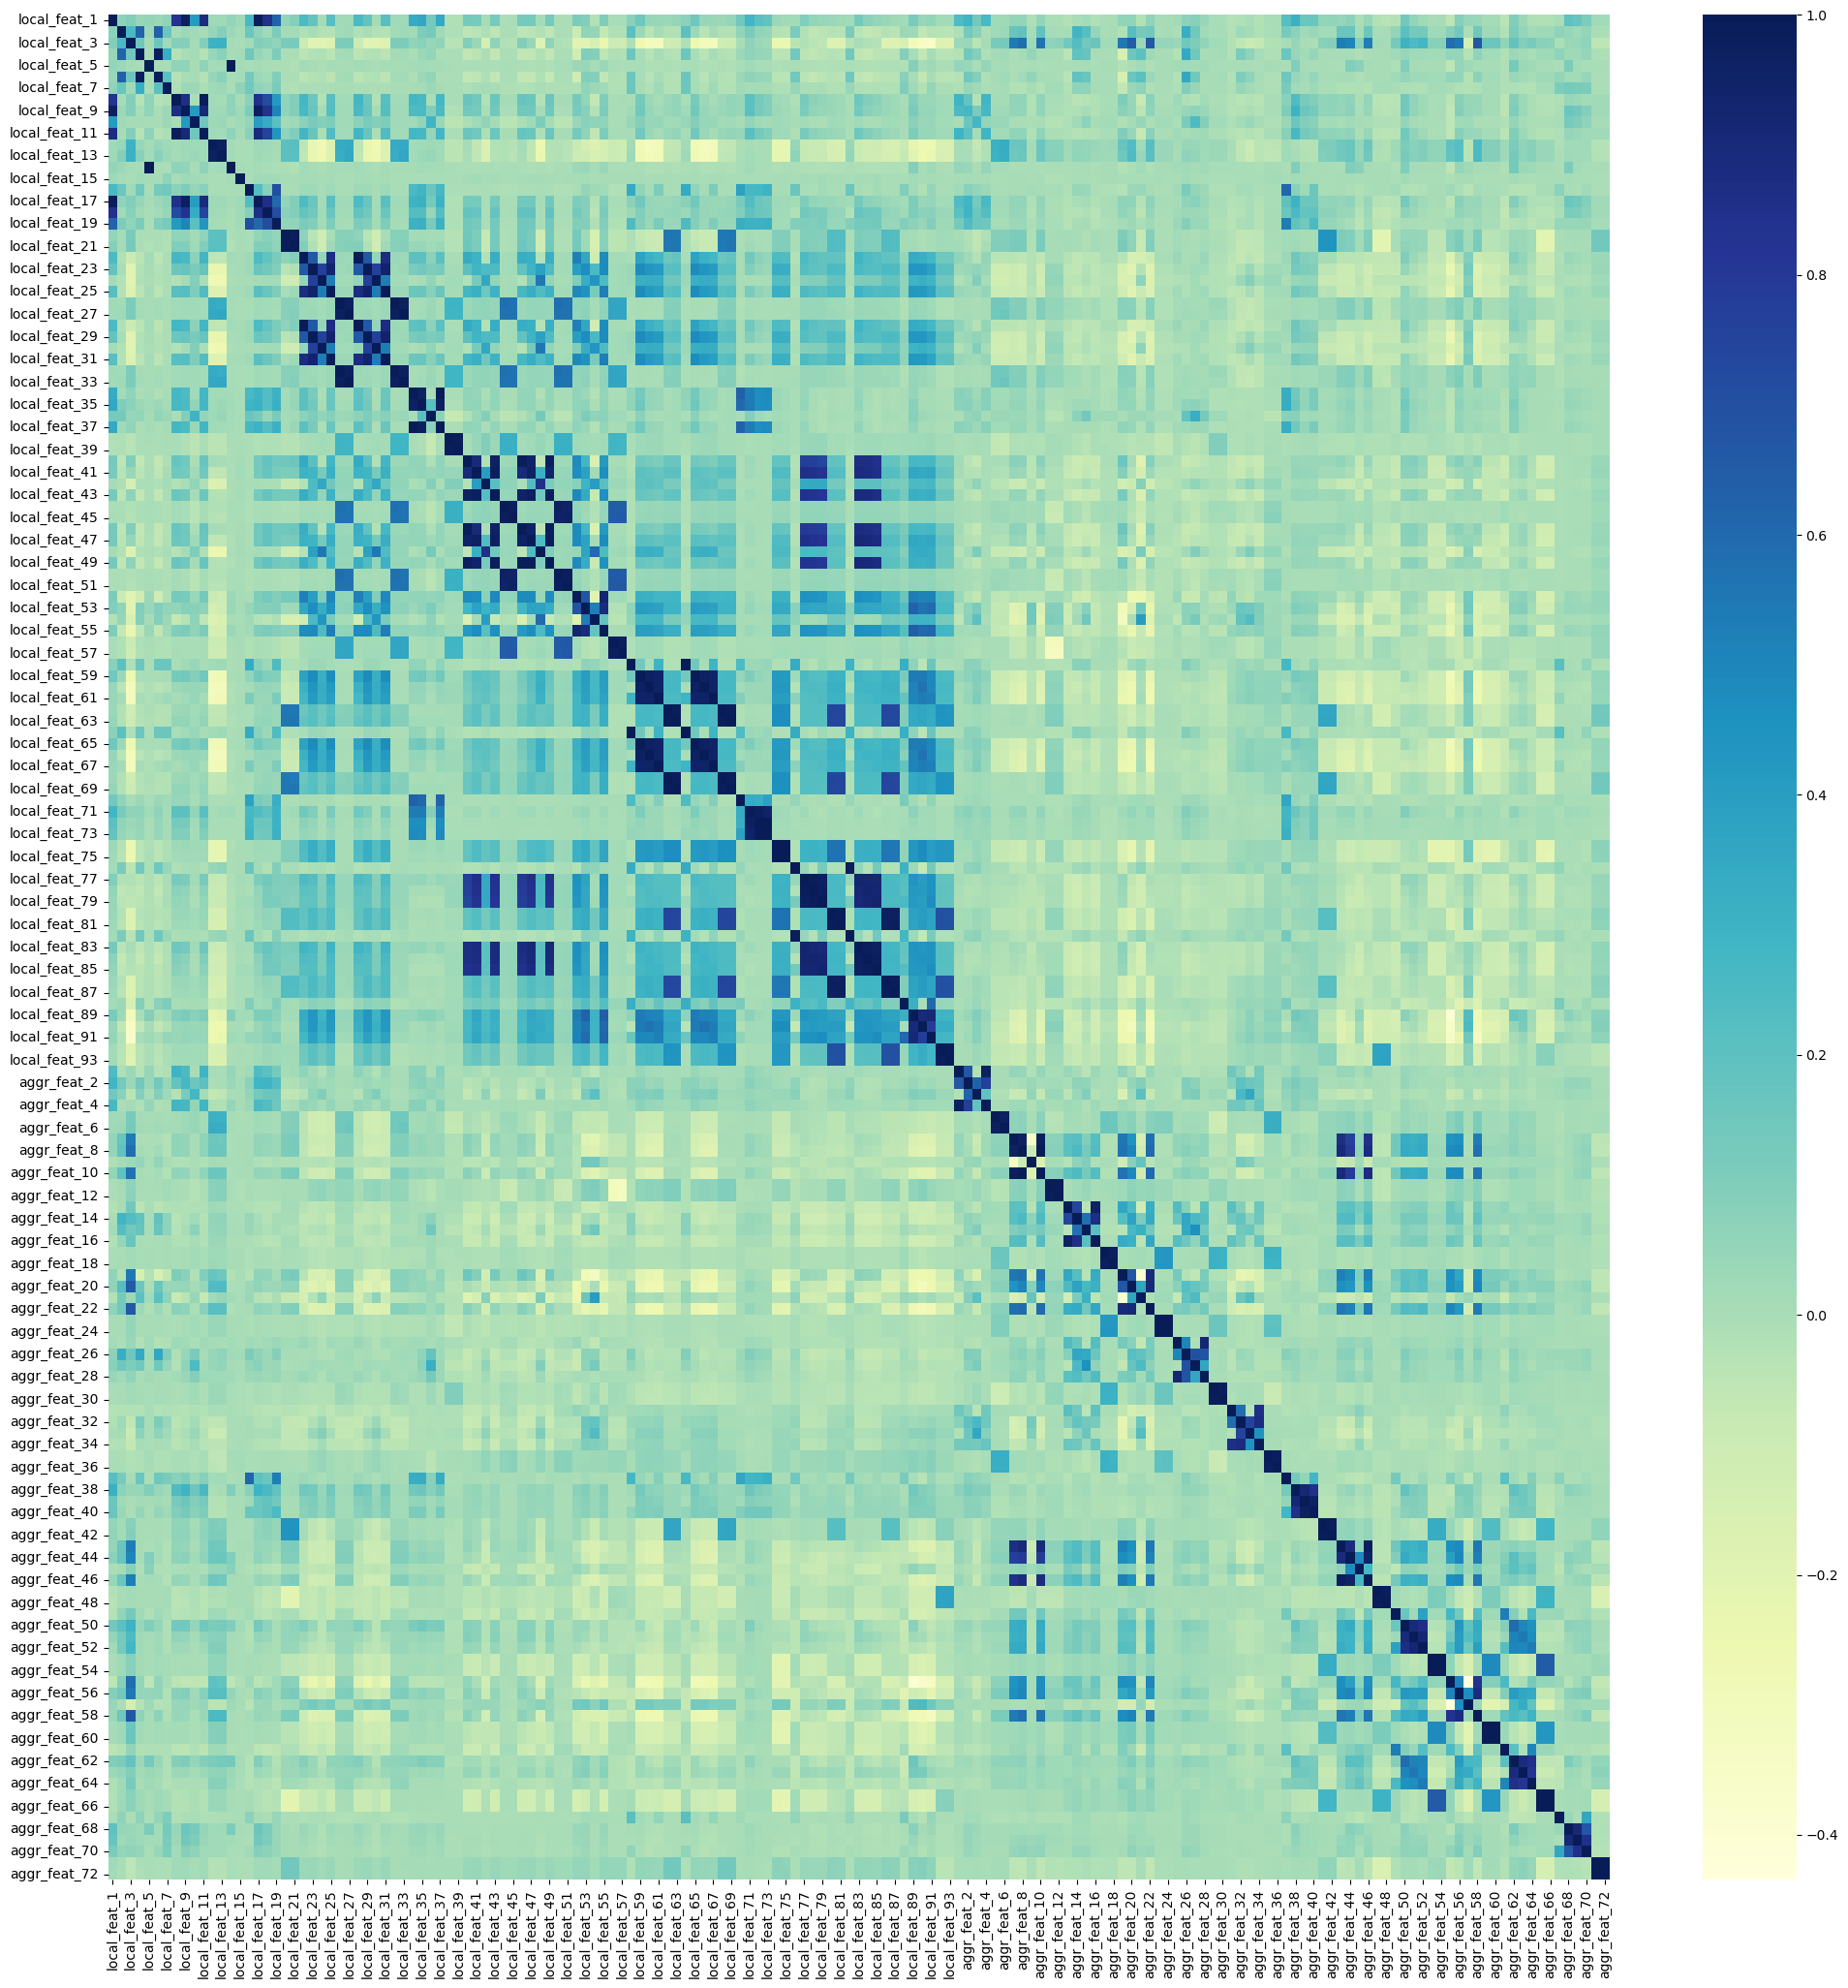

In [51]:
covariance_mat = Z.cov()

plt.figure(figsize = (25,25))

sns.heatmap(covariance_mat, cmap = 'YlGnBu')
plt.show()

In [52]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_mat)
print('Eigen Values:\n', eigenvalues)
print('Eigen values Shape:', eigenvalues.shape)
print('Eigen Vector Shape:', eigenvectors.shape)

Eigen Values:
 [ 1.96181521e+01  1.13313898e+01  8.21239820e+00  7.50542239e+00
  7.15347712e+00  6.08918955e+00  4.96528979e+00  4.56037827e+00
  4.18005257e+00  3.93973688e+00  3.74177686e+00  3.58884089e+00
  3.25499548e+00  3.20353339e+00  3.02645158e+00  2.84669279e+00
  2.77118791e+00  2.67013094e+00  2.62920552e+00  2.48521889e+00
  2.37458498e+00  2.25731478e+00  2.06334678e+00  1.96440114e+00
  1.91812928e+00  1.86476758e+00  1.80053416e+00  1.71684801e+00
  1.69864079e+00  1.62645248e+00  1.61155578e+00  1.50576828e+00
  1.48876364e+00  1.46313211e+00  1.34999068e+00  1.39757064e+00
  1.28138989e+00  1.23005883e+00  1.19736048e+00  1.11622360e+00
  1.07616798e+00  9.75913191e-01  1.05917298e+00  1.00367569e+00
  1.02074057e+00  1.03487123e+00  9.45162007e-01  9.28675963e-01
  8.99339893e-01  7.94108303e-01  8.12105379e-01  8.54329491e-01
  8.33347472e-01  8.66577943e-01  7.52618760e-01  7.24414598e-01
  6.79844613e-01  6.60890966e-01  6.26312490e-01  6.03688225e-01
  5.760305

In [53]:
# Index the eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]

# Sort the eigenvalues in descending order
eigenvalues = eigenvalues[idx]

# Sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:,idx]

In [54]:
explained_var = np.cumsum(eigenvalues)/ np.sum(eigenvalues)
explained_var

array([0.11889789, 0.18757298, 0.23734509, 0.2828325 , 0.32618691,
       0.36309109, 0.39318375, 0.42082241, 0.44615606, 0.47003325,
       0.49271069, 0.51446124, 0.53418848, 0.55360384, 0.57194597,
       0.58919865, 0.60599373, 0.62217634, 0.63811092, 0.65317285,
       0.66756428, 0.68124497, 0.69375011, 0.70565557, 0.71728059,
       0.72858222, 0.73949454, 0.74989968, 0.76019448, 0.77005176,
       0.77981877, 0.78894464, 0.79796745, 0.80683491, 0.81530504,
       0.8234868 , 0.8312528 , 0.8387077 , 0.84596443, 0.85272942,
       0.85925165, 0.86567088, 0.87194283, 0.87812914, 0.88421202,
       0.89012665, 0.8958549 , 0.90148324, 0.90693378, 0.91218577,
       0.91736353, 0.92241412, 0.92733597, 0.93214875, 0.93671007,
       0.94110046, 0.94522073, 0.94922613, 0.95302197, 0.95668068,
       0.96017178, 0.96358991, 0.96682417, 0.96981024, 0.97248912,
       0.97509842, 0.97763621, 0.98007269, 0.98227955, 0.98434152,
       0.98618779, 0.98775095, 0.98917274, 0.99030816, 0.99124

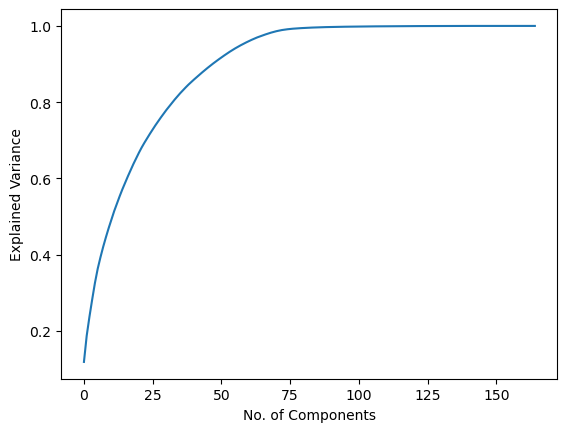

In [55]:
plt.plot(explained_var)
plt.xlabel('No. of Components')
plt.ylabel('Explained Variance')
plt.show()

In [56]:
# Selecting numbers components which explains more than 95% of the variance in the data

n_components = np.argmax(explained_var >= 0.95) + 1
n_components

59